In [1]:
import numpy as np
import pickle as pkl
import torch


In [2]:
s1 = np.load('/orcd/data/omarabu/001/tanush20/data/MERFISH/S1R1.npz', allow_pickle=True)
with open('/orcd/data/omarabu/001/njwfish/counting_flows/results/merfish/x_0_generated_new_0.pkl', 'rb') as f:
    predicted_counts = pkl.load(f)
combined_predicted_counts = torch.vstack(predicted_counts)


In [3]:
# Convert predicted counts to s1 format
print("Converting predicted counts to s1 format...")

# Get the original spots structure from s1
imgs = s1['imgs'][:]
original_spots = s1['spots']
n_spots = len(original_spots)

# Create new spots array with consecutive indices
new_spots = []
current_index = 0
cells_to_remove = []
total_cells = 0
for i in range(n_spots):
    # Get number of cells in this spot from original data
    num_cells_in_spot = 0
    for cell in original_spots[i]:
        if max(imgs[cell].shape)>256:
            cells_to_remove.append(cell)
        else:
            num_cells_in_spot += 1
    total_cells += num_cells_in_spot
            
    # Create array of consecutive indices for this spot
    spot_indices = np.arange(current_index, current_index + num_cells_in_spot)
    new_spots.append(spot_indices)
    
    # Update current index for next spot
    current_index += num_cells_in_spot

print(f"Created {len(new_spots)} spots")
print(f"Total cells: {current_index}")
print(f"Combined predicted counts shape: {combined_predicted_counts.shape}")

# Verify the conversion
print("\nVerification:")
print(f"Original spots[0]: {original_spots[0][:5]}... (length: {len(original_spots[0])})")
print(f"New spots[0]: {new_spots[0][:5]}... (length: {len(new_spots[0])})")
print(f"Original spots[1]: {original_spots[1][:5]}... (length: {len(original_spots[1])})")
print(f"New spots[1]: {new_spots[1][:5]}... (length: {len(new_spots[1])})")


Converting predicted counts to s1 format...
Created 4358 spots
Total cells: 73613
Combined predicted counts shape: torch.Size([157669, 649])

Verification:
Original spots[0]: [30684 30690 30692 30693 30698]... (length: 5)
New spots[0]: [0 1 2 3 4]... (length: 5)
Original spots[1]: [30683 30688 30694 30697 30699]... (length: 11)
New spots[1]: [5 6 7 8 9]... (length: 11)


In [4]:
# Convert torch tensor to numpy if needed
if isinstance(combined_predicted_counts, torch.Tensor):
    combined_predicted_counts_np = combined_predicted_counts.cpu().numpy()
else:
    combined_predicted_counts_np = combined_predicted_counts
combined_predicted_counts_np = combined_predicted_counts_np[:total_cells]
# Create the new data structure in s1 format
predicted_s1_format = {
    'predicted_counts': combined_predicted_counts_np,  # Combined counts matrix
    'spots': new_spots,  # List of arrays with cell indices for each spot
    'imgs': s1['imgs'],  # Copy other fields from original s1
    'x_um': s1['x_um'],
    'y_um': s1['y_um']
}

print("Created predicted_s1_format with keys:", list(predicted_s1_format.keys()))
print(f"Counts shape: {predicted_s1_format['predicted_counts'].shape}")
print(f"Number of spots: {len(predicted_s1_format['spots'])}")


Created predicted_s1_format with keys: ['predicted_counts', 'spots', 'imgs', 'x_um', 'y_um']
Counts shape: (73613, 649)
Number of spots: 4358


In [5]:
new_spots = np.array(new_spots, dtype=object)

np.savez("/orcd/data/omarabu/001/tanush20/data/MERFISH/S1R1_predicted_counts_5.npz",
        spots = new_spots,
        counts = predicted_s1_format['predicted_counts'])

In [6]:
# Load both datasets for evaluation
print("Loading datasets for evaluation...")
true_data = np.load('/orcd/data/omarabu/001/tanush20/data/MERFISH/S1R1.npz', allow_pickle=True)
predicted_data = np.load('/orcd/data/omarabu/001/tanush20/data/MERFISH/S1R1_predicted_counts_5.npz', allow_pickle=True)

print(f"True data keys: {list(true_data.keys())}")
print(f"Predicted data keys: {list(predicted_data.keys())}")
print(f"True counts shape: {true_data['counts'].shape}")
print(f"Predicted counts shape: {predicted_data['counts'].shape}")
print(f"Number of spots: {len(true_data['spots'])}")


Loading datasets for evaluation...
True data keys: ['imgs', 'counts', 'spots', 'x_um', 'y_um', 'annotations', 'visium_simulated', 'cell_type_counts', 'n_cells']
Predicted data keys: ['spots', 'counts']
True counts shape: (78329, 649)
Predicted counts shape: (73613, 649)
Number of spots: 4358


In [7]:
import os
os.chdir('/orcd/data/omarabu/001/tanush20/counting_flows_')
from metrics import *


In [8]:
# Evaluation function
def evaluate_predictions(true_data, predicted_data, imgs, max_img_size=256):
    """
    Evaluate predicted counts against true counts and spot means
    
    Args:
        true_data: npz file with true data
        predicted_data: npz file with predicted data
        max_img_size: maximum image size to consider (default 256)
    
    Returns:
        dict with MSE results
    """
    true_counts = true_data['counts']
    predicted_counts = predicted_data['counts']
    true_spots = true_data['spots']
    predicted_spots = predicted_data['spots']
    
    n_spots = len(true_spots)
    
    # Store MSE results for each spot
    metrics_pred_vs_true = {}
    metrics_pred_vs_spot_mean = {}
    metrics_true_vs_spot_mean = {}
    metrics = ['energy_distance', 'wasserstein_distance', 'mmd_rbf','mse']
    for metric in metrics:
        metrics_pred_vs_true[metric] = []
        metrics_pred_vs_spot_mean[metric] = []
        metrics_true_vs_spot_mean[metric] = []
    valid_spots = 0
    n_cells = []
    
    print(f"Evaluating {n_spots} spots...")
    
    for spot_idx in range(n_spots):
        if spot_idx % 500 == 0:
            print(f"Processing spot {spot_idx}/{n_spots}")
        
        # Get cell indices for this spot
        true_cell_indices = np.array(true_spots[spot_idx]).astype(int)
        predicted_cell_indices = np.array(predicted_spots[spot_idx]).astype(int)
        
        # Get counts for this spot
        true_spot_counts = true_counts[true_cell_indices]
        predicted_spot_counts = predicted_counts[predicted_cell_indices]
        
        # Filter cells based on image size (only for true data since predicted is already filtered)
        valid_cells = []
        for i,cell_idx in enumerate(true_cell_indices):
            cell_img = imgs[cell_idx]
            if max(cell_img.shape) <= 256:  # Fixed: should be <= not >
                valid_cells.append(i)
        if len(valid_cells) == 0:
            continue  # Skip spots with no valid cells
        n_cells.append(len(valid_cells))
        
        # Filter true counts to only valid cells (predicted is already filtered)
        true_spot_counts_valid = true_spot_counts[valid_cells]
        predicted_spot_counts_valid = predicted_spot_counts  # Already filtered

        # Calculate spot mean from true counts (filtered)
        spot_mean = np.mean(true_spot_counts_valid, axis=0)
        
        # Calculate MSE: predicted vs true
        mse_pred_true = np.mean((predicted_spot_counts_valid - true_spot_counts_valid) ** 2)
        metrics_pred_vs_true['mse'].append(mse_pred_true)
        
        # Calculate MSE: predicted vs spot mean
        mse_pred_mean = np.mean((predicted_spot_counts_valid - spot_mean) ** 2)
        metrics_pred_vs_spot_mean['mse'].append(mse_pred_mean)
        
        # Calculate MSE: true vs spot mean
        mse_true_mean = np.mean((true_spot_counts_valid - spot_mean) ** 2)
        metrics_true_vs_spot_mean['mse'].append(mse_true_mean)
        
        valid_spots += 1

        d = {}
        d['x0_target'] = true_spot_counts_valid
        d['x0_generated'] = predicted_spot_counts_valid
        res_true_vs_predicted = compute_comprehensive_metrics(d)
        for metric in metrics:
            if metric == 'mse':
                continue
            metrics_pred_vs_true[metric].append(res_true_vs_predicted[metric])

        d = {}
        d['x0_target'] = spot_mean.reshape(1,-1)
        d['x0_target'] = np.tile(spot_mean, (len(predicted_spot_counts_valid), 1))
        d['x0_generated'] = predicted_spot_counts_valid
        res_pred_vs_spot_mean = compute_comprehensive_metrics(d)
        for metric in metrics:
            if metric == 'mse':
                continue
            metrics_pred_vs_spot_mean[metric].append(res_pred_vs_spot_mean[metric])

        d = {}
        d['x0_target'] = true_spot_counts_valid
        d['x0_generated'] = spot_mean.reshape(1,-1)
        d['x0_generated'] = np.tile(spot_mean, (len(true_spot_counts_valid), 1))
        res_true_vs_spot_mean = compute_comprehensive_metrics(d)
        for metric in metrics:
            if metric == 'mse':
                continue
            metrics_true_vs_spot_mean[metric].append(res_true_vs_spot_mean[metric])
    
    return metrics_pred_vs_true, metrics_pred_vs_spot_mean, metrics_true_vs_spot_mean

# Run evaluation
print("Starting evaluation...")
metrics_pred_vs_true, metrics_pred_vs_spot_mean, metrics_true_vs_spot_mean = evaluate_predictions(true_data, predicted_data, imgs, max_img_size=256)


Starting evaluation...
Evaluating 4358 spots...
Processing spot 0/4358


/orcd/data/omarabu/001/tanush20/counting_flows_/metrics.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return float(np.mean(np.abs(scipy.stats.skew(X, axis=0) - scipy.stats.skew(Y, axis=0))))
/orcd/data/omarabu/001/tanush20/counting_flows_/metrics.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return float(np.mean(np.abs(scipy.stats.kurtosis(X, axis=0) - scipy.stats.kurtosis(Y, axis=0))))
/orcd/data/omarabu/001/tanush20/counting_flows_/metrics.py:80: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_X = np.cov(X.T)
/home/njwfish/miniconda3/envs/sc/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/njwfish/minicond

Processing spot 500/4358
Processing spot 1000/4358
Processing spot 1500/4358
Processing spot 2000/4358
Processing spot 2500/4358
Processing spot 3000/4358
Processing spot 3500/4358
Processing spot 4000/4358


In [9]:
import pandas as pd
metrics = ['energy_distance', 'wasserstein_distance', 'mmd_rbf']

# collect results into a list of dicts
rows = []
for metric in metrics:
    rows.append({
        "Metric": metric,
        "Pred vs True": np.mean(metrics_pred_vs_true[metric]),
        "Pred vs Spot Mean": np.mean(metrics_pred_vs_spot_mean[metric]),
        "True vs Spot Mean": np.mean(metrics_true_vs_spot_mean[metric]),
    })

# turn into DataFrame for neat printing
df = pd.DataFrame(rows)
df.set_index('Metric', inplace=True)
df = df.T
print(df.to_string(float_format="%.3f"))


Metric             energy_distance  wasserstein_distance  mmd_rbf
Pred vs True                 8.891                 0.017    0.203
Pred vs Spot Mean           42.903                 0.034    0.419
True vs Spot Mean           41.717                 0.030    0.409


In [19]:
true_data.keys()

KeysView(NpzFile '/orcd/data/omarabu/001/tanush20/data/MERFISH/S1R1.npz' with keys: imgs, counts, spots, x_um, y_um...)

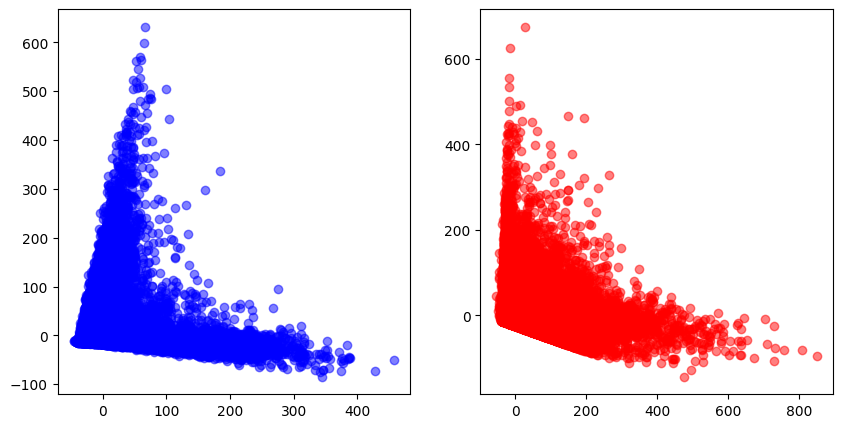

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

true_counts = true_data['counts']
predicted_counts = predicted_data['counts']

# pca true counts
pca = PCA(n_components=2)
pca.fit(true_counts)
true_counts_pca = pca.transform(true_counts)
predicted_counts_pca = pca.transform(predicted_counts)

# plot true counts pca
# split into two subplots to plot true and predicted counts
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(true_counts_pca[:,0], true_counts_pca[:,1], color='blue', alpha=0.5)
axs[1].scatter(predicted_counts_pca[:,0], predicted_counts_pca[:,1], color='red', alpha=0.5)
plt.show()


/home/njwfish/miniconda3/envs/sc/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/njwfish/miniconda3/envs/sc/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


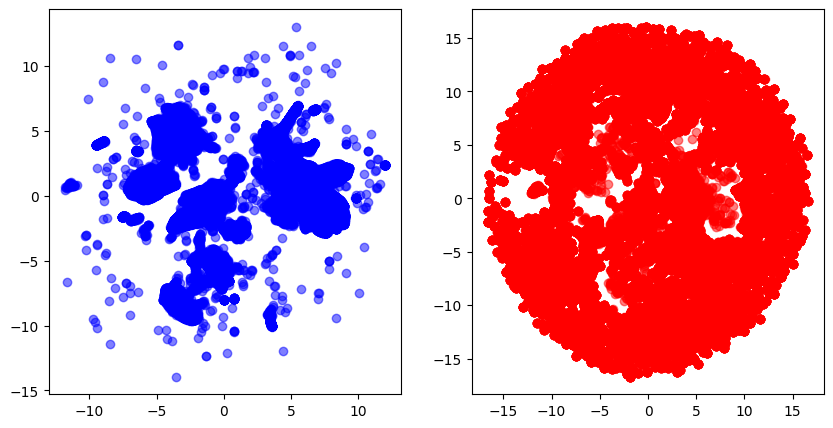

In [12]:
# umap true counts
import umap

umap = umap.UMAP(n_components=2, random_state=42)
stack_counts = np.vstack([true_counts, predicted_counts])
stack_counts_umap = umap.fit_transform(stack_counts)
true_counts_umap = stack_counts_umap[:true_counts.shape[0]]
predicted_counts_umap = stack_counts_umap[true_counts.shape[0]:]

# plot true counts tsne
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(true_counts_umap[:,0], true_counts_umap[:,1], color='blue', alpha=0.5)
axs[1].scatter(predicted_counts_umap[:,0], predicted_counts_umap[:,1], color='red', alpha=0.5)
plt.show()